## Proof of Concept for flood maps

This notebook is an attempt at translating the CoCliCo User Story into code. 

The data used is Coastal Flood Hazard Projections and can be found here: p:\11207608-coclico\FULLTRACK_DATA\WP4\

In [270]:
# Import modules

import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib
import pystac
import pystac_client
import geopandas as gpd

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# Import custom functionality
from coclicodata.drive_config import p_drive

# ignore warnings
warnings.filterwarnings("ignore")

In [194]:
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
)
collection = catalog.get_child(id = 'cfhp')

In [195]:
# Load LAU's 

# Set file path
lau_fp = r"p:\11207608-coclico\FASTTRACK_DATA\XX_LAU\LAU_RG_01M_2020_3035.shp"

# Load data
lau_data = gpd.read_file(lau_fp)

<Axes: >

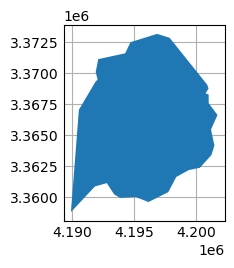

In [196]:
# Filter on the Netherlands as an example
lau_NL = lau_data.loc[lau_data["CNTR_CODE"] == "NL"] 

# Select one for testing
lau = lau_data.loc[lau_data["LAU_NAME"] == "Varel, Stadt"] 

lau.plot()

In [197]:
# intersecting_items = []
# for item in collection.get_items():
#     item_geometry = item.geometry
#     if item_geometry.intersects(lau['geometry'].unary_union):
#         intersecting_items.append(item)

In [262]:

for i, item in enumerate(collection.get_all_items()):
    
    if "UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif" in item.id:
        print(item.id)
        print(i)
        break


UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif
918


In [199]:
from shapely.geometry import shape

cur_item_geom = gpd.GeoDataFrame(geometry=[shape(item.geometry)])

[item_geom] = item.properties['proj:geometry']['coordinates']


In [200]:
item

<Item id=UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=4005362_y=2958337.tif>

Working on: Varel, Stadt


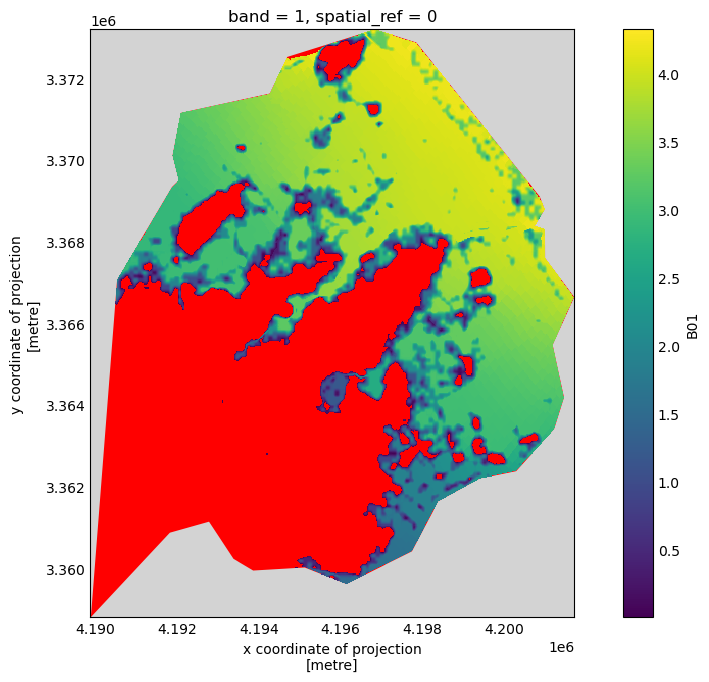

In [201]:
item_test = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_geom)])

# Generate figure
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau.plot(ax=ax, color='red')

for i, cur_lau in lau.iterrows():
    
    if cur_lau['geometry'].intersects(item_test['geometry'])[0]:
        
        print('Working on: ' + str(cur_lau['LAU_NAME']))
        # Load raw band_data dataset 
        ds = rio.open_rasterio(item.assets['band_data'].href, masked = True)

        # First clip to bounding box
        ds_clip = ds.rio.clip_box(*cur_lau.geometry.bounds)

        ds_clip 

        # Then, clip dataset to match AOI polygon
        ds_clip = ds_clip.rio.clip(cur_lau)

        del ds

# Plot data
ds_clip.plot(ax=ax)

In [202]:
# Explore xarray spatial
import xrspatial
from pystac_client import Client

pol = xr.cur_lau

xrspatial.zonal.stats(ds_clip,cur_lau['geometry'], stats_funcs = 'mean')

AttributeError: module 'xarray' has no attribute 'cur_lau'

In [ ]:
# Compute statistics

# Amount of noData's within dataset clipped to polygon
class flood_stats:
    def __init__(self):
        
        # Intialize empty lists
        self.all_nans = []
        self.all_less05 = []
        self.all_more05 = []
        self.all_total = []
        self.all_flooded = []

    def compute(self,ds):

        self.ds = ds

        # Compute number of pixels with Nan, <0.5m flood depth, and >0.5m flood depth
        self.n_nans = np.isnan(self.ds.values).sum()
        self.n_less05 = np.array([self.ds.values<0.5]).sum()
        self.n_more05 = np.array([self.ds.values>0.5]).sum()

        # Sum all to find total number of pixels
        self.total = self.n_nans + self.n_less05 + self.n_more05

        # Determine fraction of pixels that are flooded
        self.flooded = np.divide(np.add(self.n_less05, self.n_more05),self.total)

    def add_new_values(self):

        # Append values to lists
        self.all_nans.append(self.n_nans)
        self.all_less05.append(self.n_less05)
        self.all_more05.append(self.n_more05)
        self.all_total.append(self.total)
        self.all_flooded.append(self.flooded)
        
    def convert2arrays(self):

        # Convert all lists to numpy arrays
        self.all_nans = np.array(self.all_nans)
        self.all_less05 = np.array(self.all_less05)
        self.all_more05 = np.array(self.all_more05)
        self.all_total = np.array(self.all_total)
        self.all_flooded = np.array(self.all_flooded)

if __name__ == '__main__':
    
    clip_stats = flood_stats()
    clip_stats.compute(ds_clip)

    print('summed pixels = ' + str(clip_stats.total))
    print('original pixels = ' + str(np.size(ds_clip.values)))

summed pixels = 273024
original pixels = 273024


Text(0.5, 1.0, 'Percentage flooded = 37%')

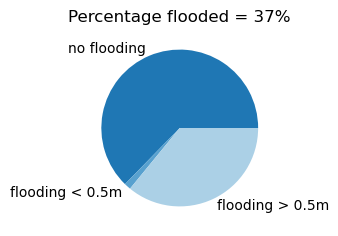

In [ ]:
# Plot data
import matplotlib.pyplot as plt

# Set plot style 
plt.style.use('_mpl-gallery')

# Set labels
labels = 'no flooding','flooding < 0.5m', 'flooding > 0.5m'
# Initiate figure
fig, ax = plt.subplots()
# Do plotting
ax.pie(np.array([clip_stats.n_nans,clip_stats.n_less05,clip_stats.n_more05]), labels = labels)
ax.set_title('Percentage flooded = ' + str(round(clip_stats.flooded*100)) + '%')

In [ ]:
import os

# Set up folder structure
folder_structure = {
    "Mean_spring_tide": [],
    "RP": ["1000", "100", "1"],
    "SLR": {
        "High_end": ["2100", "2150"],
        "SSP126": ["2100"],
        "SSP245": ["2050", "2100"],
        "SSP585": ["2030", "2050", "2100"]
    }
}

def get_paths(folder_structure, base_dir=''):
    """Generate paths for a folder structure defined by a dict"""
    paths = []
    for key, value in folder_structure.items():
        if isinstance(value, dict):
            paths.extend(get_paths(value, os.path.join(base_dir, key)))
        elif isinstance(value, list):
            if value:
                for item in value:
                    if item != "":
                        paths.append(os.path.join(base_dir, key, item))
            else:
                paths.append(os.path.join(base_dir, key))
        else:
            continue
    return paths

map_types = ["HIGH_DEFENDED_MAPS", "LOW_DEFENDED_MAPS", "UNDEFENDED_MAPS"]

path_list = get_paths(folder_structure)
path_list


['Mean_spring_tide',
 'RP\\1000',
 'RP\\100',
 'RP\\1',
 'SLR\\High_end\\2100',
 'SLR\\High_end\\2150',
 'SLR\\SSP126\\2100',
 'SLR\\SSP245\\2050',
 'SLR\\SSP245\\2100',
 'SLR\\SSP585\\2030',
 'SLR\\SSP585\\2050',
 'SLR\\SSP585\\2100']

In [ ]:
# Load all scenarios
from pathlib import Path
import time

start_time = time.time()

# Initialize flood stats class
clip_stats = flood_stats()
# Initialize empty list for collecting file paths
all_fps = []

for item in collection.get_all_items():
    # NOTE: for now only focus on low_defended map_type
    if map_types[1] in item.id and 'SLR' in str(item.id):

        # Get item bounding box geometry
        [item_boundbox] = item.properties['proj:geometry']['coordinates']
        # Transform bounding box coordinates to GeoDataFrame Polygon
        item_boundbox = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_boundbox)])
        
        # Check if lau intersects with item bounding box
        if cur_lau.geometry.intersects(item_boundbox.geometry)[0]:
    
            print('Working on: ' + str(item.id))

            # Load raw band_data dataset 
            ds = rio.open_rasterio(item.assets['band_data'].href, masked = True)

            # Clip dataset to match AOI
            ds_clip = ds.rio.clip(cur_lau)

            # Adjust FillValue (NoData) to np.nan for plotting and processing purposes
            ds_clip = ds_clip.where(ds_clip != ds_clip.attrs['_FillValue'],np.nan)
                # print("--- %s seconds ---" % (time.time() - start_time))

            # Close dataset to save memory
            del ds

    	    # Compute flood statistics for each floop_maps
            clip_stats.compute(ds_clip)
            clip_stats.add_new_values()

            # Collect all filepaths
            all_fps.append(item.id)

clip_stats.convert2arrays()


NameError: name 'flood_stats' is not defined

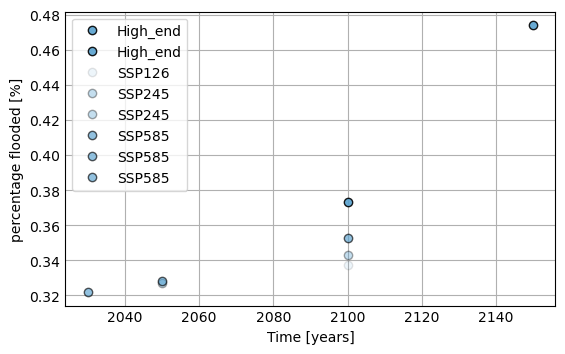

In [ ]:
# Convert list of paths to pathlib
fps = [Path(fp) for fp in all_fps]



fig, ax = plt.subplots(figsize=(5,3))

col_alpha = [0.1,0.35,0.65,0.9]
col_scen = 'SSP126', 'SSP245', 'SSP585', 'High_end'
scen = []
year = np.array([])


for i, fp in enumerate(fps):
    
    cur_scen = fp.parts[2]
    scen.append(cur_scen)
    
    year = np.append(year, int(fp.parts[-2]))
    
    ax.plot(year[i],clip_stats.all_flooded[i],'o',color = 'C1', alpha = col_alpha[col_scen.index(cur_scen)], markeredgecolor = 'black')
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('percentage flooded [%]')
ax.legend(scen)

In [269]:
# Do this for all polygons within the current tif file

    
# Add new columns to LAU dataframe
lau_data['n_nans'] = None
lau_data['n_less05'] = None
lau_data['n_more05'] = None
lau_data['total'] = None
lau_data['flooded'] = None

track = np.empty([])

# Iterate over all items
for i, item in enumerate(collection.get_all_items()):
    
    # Match with map type we're working on
    if not "UNDEFENDED_MAPS/RP/1000" in item.id:
        continue

    print('Working on ' + str(item.id))
    # Retreive item geometry
    [item_geom] = item.properties['proj:geometry']['coordinates']
    # Convert to polygon
    item_bounds = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_geom)])

    # Load raw band_data dataset 
    ds = rio.open_rasterio(item.assets['band_data'].href, masked = True)

    # Iterate over LAU's 
    for i, cur_lau in lau_data.iterrows():

        # Check if LAU intersects with flood map extent
        # TODO: change from within to intersects and find a way to deal with bordering tif's 
        if not cur_lau['geometry'].within(item_bounds['geometry'])[0]:
            continue

        # First clip to bounding box
        ds_clip = ds.rio.clip_box(*cur_lau.geometry.bounds)

        # Check if flooded pixels exist within the bounding box
        if ds_clip.isnull().all():
            continue

        track = np.append(track, i)
        
        # Update user
        print('Flooded pixels detected in: ' + str(cur_lau['LAU_NAME']))
        # Then, clip dataset to match AOI polygon
        ds_clip = ds_clip.rio.clip(cur_lau)

        # Compute flood statistics for each floop_maps
        clip_stats.compute(ds_clip)
        
        # Add stats to dataframe
        lau_data['n_nans'][i] = clip_stats.n_nans
        lau_data['n_less05'][i] = clip_stats.n_less05
        lau_data['n_more05'][i] = clip_stats.n_more05
        lau_data['total'][i] = clip_stats.total
        lau_data['flooded'][i] = clip_stats.flooded

Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=1319937.tif
Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=2139137.tif
Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=2958337.tif
Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=3777537.tif
Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=4596737.tif
Working on UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=1547762_y=941637.tif
Flooded pixels detected in: Agaete
Flooded pixels detected in: Agüimes
Flooded pixels detected in: Antigua
Flooded pixels detected in: Arrecife
Flooded pixels detected in: Artenara
Flooded pixels detected in: Arucas
Flooded pixels detected in: Betancuria
Flooded pixels detected in: Gáldar
Flooded pixels detected in: Haría
Flooded pixels detected in: Ingenio
Flooded pixels detected in: Mogán
Flooded pixels detected in: Moya
Flooded pixels detected in: Oliva, La
Flooded pixels detected in: Pájara
Flooded pixels detected in: Palmas de Gran Canaria, Las
Flooded

In [273]:
# Reduce data frame to only those lau's that have been altered
altered_lau_data = lau_data.loc[~lau_data.flooded.isna()]
altered_lau_data

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2020,POP_DENS_2,AREA_KM2,YEAR,FID,geometry,n_nans,n_less05,n_more05,total,flooded
1192,DE_03361001,DE,03361001,"Achim, Stadt",31923.0,471.398771,67.719735,2020,DE_03361001,"POLYGON ((4258927.295 3320011.519, 4259193.583...",201623,7,0,201630,0.000035
1193,DE_03361002,DE,03361002,Blender,2885.0,75.034640,38.448908,2020,DE_03361002,"POLYGON ((4264556.862 3317435.819, 4265677.354...",108798,12,0,108810,0.00011
1195,DE_03361003,DE,03361003,Dörverden,9009.0,107.940908,83.462333,2020,DE_03361003,"POLYGON ((4275479.269 3295636.790, 4275328.930...",293402,4,0,293406,0.000014
1197,DE_03361005,DE,03361005,Kirchlinteln,9911.0,56.675823,174.871744,2020,DE_03361005,"POLYGON ((4272425.673 3310568.711, 4274136.202...",481806,0,0,481806,0.0
1199,DE_03361008,DE,03361008,"Ottersberg, Flecken",12957.0,131.054282,98.867430,2020,DE_03361008,"POLYGON ((4262891.981 3325140.583, 4263517.185...",501291,21,0,501312,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97643,SE_1381,SE,1381,Laholm,25903.0,28.573539,906.538054,2020,SE_1381,"POLYGON ((4523898.940 3736200.596, 4525114.666...",2284884,400,1378,2286662,0.000778
97647,SE_1384,SE,1384,Kungsbacka,84395.0,131.607659,641.262069,2020,SE_1384,"MULTIPOLYGON (((4464853.012 3807859.367, 44629...",1793389,1551,3325,1798265,0.002712
97913,SI_040,SI,040,Izola/Isola,16486.0,576.666138,28.588466,2020,SI_040,"POLYGON ((4608627.456 2493998.714, 4608321.906...",82184,34,10,82228,0.000535
97924,SI_050,SI,050,Koper/Capodistria,52630.0,173.570480,303.219764,2020,SI_050,"POLYGON ((4618821.710 2488901.192, 4618978.423...",834474,214,692,835380,0.001085


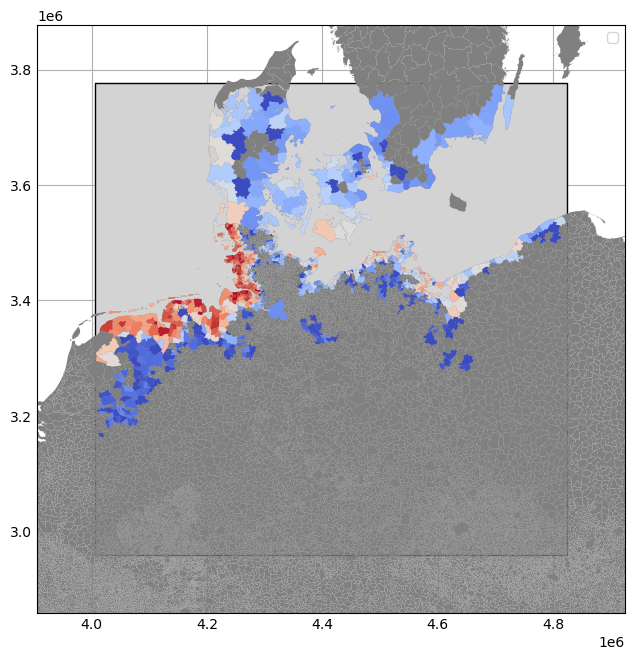

In [250]:
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau_data.plot(ax=ax, color='gray')
cmap = 'coolwarm'
altered_lau_data.plot(ax=ax, column='flooded', cmap=cmap, legend=True)

# Set the zoom level to the extent of the first plot
ax.set_xlim(item_test.total_bounds[0]-0.1e6, item_test.total_bounds[2]+0.1e6)
ax.set_ylim(item_test.total_bounds[1]-0.1e6, item_test.total_bounds[3]+0.1e6)

ax.legend(['test1','test2','test4'])

# Show the plot
plt.show()


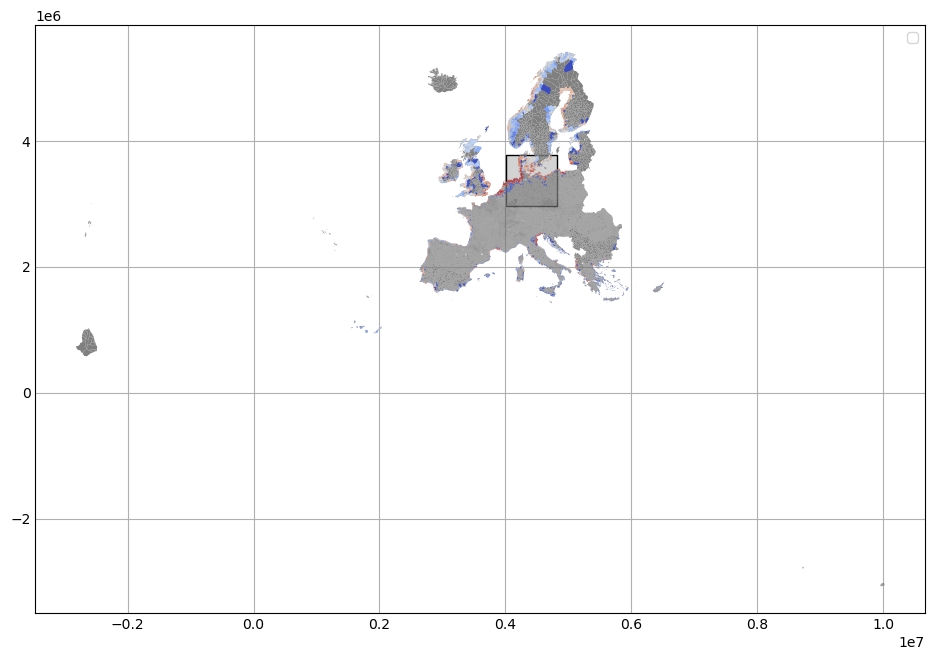

In [274]:
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau_data.plot(ax=ax, color='gray')
cmap = 'coolwarm'
altered_lau_data.plot(ax=ax, column='flooded', cmap=cmap, legend=True)

ax.legend(['test1','test2','test4'])

# Show the plot
plt.show()

In [275]:
# Write both geodataframes

coclico_data_dir = p_drive.joinpath("11207608-coclico", "FULLTRACK_DATA")
ds_dir = coclico_data_dir.joinpath('WP4','LAU_stats')
out_file_altered = ds_dir.joinpath('UNDEFENDED_RP1000_only_adjusted.parquet')
out_file= ds_dir.joinpath('UNDEFENDED_RP1000.parquet')

altered_lau_data.to_parquet(out_file_altered)
lau_data.to_parquet(out_file)


In [271]:
item.id

'UNDEFENDED_MAPS/SLR/SSP585/2100/B01_epsg=3035_x=6462962_y=941637.tif'

In [258]:
len(items)

42